<a href="https://colab.research.google.com/github/mmzznno/tumor_MRI/blob/main/tumor_mri.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive #Googleドライブにマウントし、ファイルへアクセス
drive.mount('/content/drive')

Mounted at /content/drive


In [43]:
import os
import cv2
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt

In [40]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Optimizer

In [30]:
# ファイルパスの設定
path = '/content/drive/MyDrive/archive/'

path_yes = path + 'yes/'
path_no = path + 'no/'

# 画像をリストで取得
list_yes = os.listdir(path_yes)
list_no = os.listdir(path_no)

In [32]:
#すべての画像ファイルを50 x 50の配列に変換(2m23s)
img_yes = []
img_no = []

for i in range(len(list_yes)):
    img = cv2.imread(path_yes + list_yes[i])
    b,g,r = cv2.split(img)
    img = cv2.merge([r,g,b])
    img = cv2.resize(img, (50,50))
    img_yes.append(img)

for i in range(len(list_no)):
    img = cv2.imread(path_no + list_no[i])
    b,g,r = cv2.split(img)
    img = cv2.merge([r,g,b])
    img = cv2.resize(img, (50,50))
    img_no.append(img)

In [34]:
#結合して並べ替え
X = np.array(img_yes + img_no)
y =  np.array([0]*len(img_yes) + [1]*len(img_no))

#画像の順番をシャッフル（これやらないと精度がバタバタ増減する）
rand_index = np.random.permutation(np.arange(len(X)))
X = X[rand_index]
y = y[rand_index]

#データを訓練データとテストデータに分割
X_train = X[:int(len(X)*0.8)]
y_train = y[:int(len(y)*0.8)]
X_test = X[int(len(X)*0.8):]
y_test = y[int(len(y)*0.8):]

#To_categolizeで正解ラベルを作成する
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [35]:
# input_tensorの定義をして、vggのImageNetによる学習済みモデルを作成
input_tensor = Input(shape=(50,50,3))
vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)

# 特徴量抽出部分のモデルを作成
top_model = Sequential()
top_model.add(Flatten(input_shape=vgg16.output_shape[1:]))
top_model.add(Dense(256, activation='sigmoid'))
top_model.add(Dropout(0.5))
top_model.add(Dense(2, activation='softmax'))

# vgg16とtop_modelを連結
model = Model(inputs=vgg16.input, outputs=top_model(vgg16.output))

# 19層目までの重みを固定
for layer in model.layers[:19]:
    layer.trainable =  False

#　学習の前に、モデル構造を確認
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50, 50, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 50, 50, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 50, 50, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 25, 25, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 25, 25, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 2)              │       131,842 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,846,530 (56.64 MB)

 Trainable params: 131,842 (515.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [36]:
for layer in model.layers[:19]:
    layer.trainable =  False

In [42]:
# モデルのコンパイル
model.compile(loss='categorical_crossentropy',
                            metrics=['accuracy'])

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 50, 50, 3))
  warnings.warn(msg)


3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - accuracy: 0.5746 - loss: 0.9149 - val_accuracy: 0.6863 - val_loss: 0.6089
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.6368 - loss: 0.7092 - val_accuracy: 0.7451 - val_loss: 0.4799
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.8010 - loss: 0.4205 - val_accuracy: 0.7451 - val_loss: 0.4361
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.8333 - loss: 0.3975 - val_accuracy: 0.7647 - val_loss: 0.4349
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.8047 - loss: 0.3810 - val_accuracy: 0.7647 - val_loss: 0.4448
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.8607 - loss: 0.3201 - val_accuracy: 0.7647 - val_loss: 0.4301
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.8059 - loss: 0.4186 - val_accuracy: 0.7255 - val_loss: 0.4254
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.8706 - loss: 0.3164 - val_accuracy: 0.7647 - val_loss: 0.5032
Epoch 9/10
3/3 ━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 899ms/step - accuracy: 0.7128 - loss: 0.4717
Test loss: 0.45414766669273376
Test accuracy: 0.7254902124404907


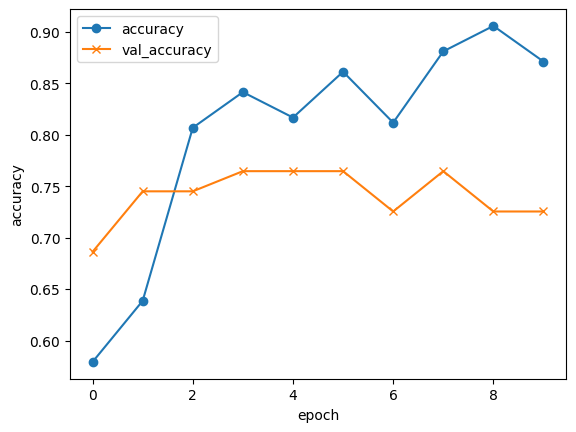

In [44]:
# モデルの学習
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=100, epochs=10)

# モデルの保存
model.save('model.h5')

# 精度の評価
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# 学習履歴
plt.plot(history.history["accuracy"], label="accuracy", ls="-", marker="o")
plt.plot(history.history["val_accuracy"], label="val_accuracy", ls="-", marker="x")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(loc="best")
plt.show()